***SudokuCV - Solving sudoku from image of unsolved puzzle***

Importing Libraries

In [41]:
!pip install dlx
import sys
from functools import reduce
import dlx
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, random
import cv2
from glob import glob
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score, classification_report
from pathlib import Path
from PIL import Image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for dlx: filename=dlx-1.0.4-py3-none-any.whl size=5718 sha256=85eeff817dbbe88b9ac66815a214f0aa6eec9adcb265a3cc8086ca67edb1cbfe
  Stored in directory: /root/.cache/pip/wheels/78/55/c8/dc61e772445a566b7608a476d151e9dcaf4e092b01b0c4bc3c
Successfully built dlx


Loading data

In [19]:
data = os.listdir("/content/drive/MyDrive/Digits")
data_X = []     
data_y = []  
data_classes = len(data)

for i in range (0,data_classes):
    data_list = os.listdir("/content/drive/MyDrive/Digits/"+str(i))
    for j in data_list:
        pic = cv2.imread("/content/drive/MyDrive/Digits/"+str(i)+"/"+j)
        pic = cv2.resize(pic,(32,32))
        data_X.append(pic)
        data_y.append(i)
 
if len(data_X) == len(data_y) :
    print("Total Datapoints = ",len(data_X))

data_X = np.array(data_X)
data_y = np.array(data_y)

Total Datapoints =  10160


In [20]:
#spliting the train validation and test sets
train_X, test_X, train_y, test_y = train_test_split(data_X,data_y,test_size=0.05)
train_X, valid_X, train_y, valid_y = train_test_split(train_X,train_y,test_size=0.2)
print("Training Set Shape = ",train_X.shape)
print("Validation Set Shape = ",valid_X.shape)
print("Test Set Shape = ",test_X.shape)

Training Set Shape =  (7721, 32, 32, 3)
Validation Set Shape =  (1931, 32, 32, 3)
Test Set Shape =  (508, 32, 32, 3)


Data Preprocessing

In [21]:
def Prep(img):
    #making image grayscale
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) 
    #histogram equalization to enhance contrast
    img = cv2.equalizeHist(img)
    #normalizing
    img = img/255 
    return img

train_X = np.array(list(map(Prep, train_X)))
test_X = np.array(list(map(Prep, test_X)))
valid_X= np.array(list(map(Prep, valid_X)))

#reshaping the images
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], train_X.shape[2],1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], test_X.shape[2],1)
valid_X = valid_X.reshape(valid_X.shape[0], valid_X.shape[1], valid_X.shape[2],1)

#augmentation
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.2, shear_range=0.1, rotation_range=10)
datagen.fit(train_X)

#one hot encoding of the labels
train_y = to_categorical(train_y, data_classes)
test_y = to_categorical(test_y, data_classes)
valid_y = to_categorical(valid_y, data_classes)

Building and Training Model

In [22]:
model = Sequential()

model.add((Conv2D(60,(5,5),input_shape=(32, 32, 1) ,padding = 'Same' ,activation='relu')))
model.add((Conv2D(60, (5,5),padding="same",activation='relu')))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add((Conv2D(30, (3,3),padding="same", activation='relu')))
model.add((Conv2D(30, (3,3), padding="same", activation='relu')))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(500,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 60)        1560      
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 60)        90060     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 60)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 30)        16230     
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 30)        8130      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 8, 30)         0         
 2D)                                                  

In [23]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon = 1e-08, decay=0.0)
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(datagen.flow(train_X, train_y, batch_size=32), epochs = 100, validation_data = (valid_X, valid_y), verbose = 2, steps_per_epoch= 200)

score = model.evaluate(test_X, test_y, verbose=0)
print('Test Score = ',score[0])
print('Test Accuracy =', score[1])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 2/100
200/200 - 3s - loss: 0.2970 - accuracy: 0.9064 - val_loss: 0.0619 - val_accuracy: 0.9798 - 3s/epoch - 14ms/step
Epoch 3/100
200/200 - 3s - loss: 0.2180 - accuracy: 0.9337 - val_loss: 0.0443 - val_accuracy: 0.9876 - 3s/epoch - 14ms/step
Epoch 4/100
200/200 - 3s - loss: 0.1497 - accuracy: 0.9512 - val_loss: 0.0529 - val_accuracy: 0.9839 - 3s/epoch - 13ms/step
Epoch 5/100
200/200 - 3s - loss: 0.1279 - accuracy: 0.9586 - val_loss: 0.0332 - val_accuracy: 0.9896 - 3s/epoch - 14ms/step
Epoch 6/100
200/200 - 3s - loss: 0.1247 - accuracy: 0.9606 - val_loss: 0.0299 - val_accuracy: 0.9912 - 3s/epoch - 14ms/step
Epoch 7/100
200/200 - 3s - loss: 0.1200 - accuracy: 0.9639 - val_loss: 0.0266 - val_accuracy: 0.9927 - 3s/epoch - 14ms/step
Epoch 8/100
200/200 - 3s - loss: 0.1004 - accuracy: 0.9697 - val_loss: 0.0342 - val_accuracy: 0.9865 - 3s/epoch - 14ms/step
Epoch 9/100
200/200 - 3s - loss: 0.0910 - accuracy: 0.9719 - val_loss: 0.0248 - val_accuracy: 0.9912 - 3s/epoch - 14ms/step
Epoch 10

Reading the Sudoku

<function matplotlib.pyplot.show>

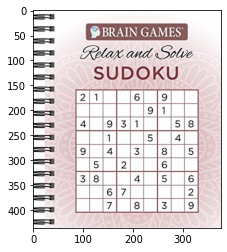

In [25]:
sudoku_a = cv2.imread("/content/drive/MyDrive/1.jpg")
plt.figure()
plt.imshow(sudoku_a)
plt.show

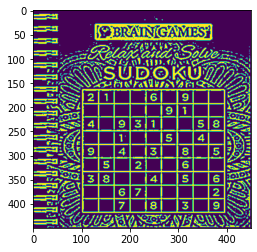

In [26]:
#preprocessing
sudoku_a = cv2.resize(sudoku_a, (450,450))

# function to greyscale, blur and change the receptive threshold of image
def preprocess(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    blur = cv2.GaussianBlur(gray, (3,3),6) 
    threshold_img = cv2.adaptiveThreshold(blur,255,1,1,11,2)
    return threshold_img

threshold = preprocess(sudoku_a)

plt.figure()
plt.imshow(threshold)
plt.show()


Detecting Contours

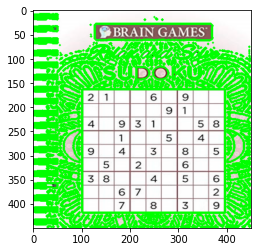

In [27]:
contour_1 = sudoku_a.copy()
contour_2 = sudoku_a.copy()
contour, hierarchy = cv2.findContours(threshold,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(contour_1, contour,-1,(0,255,0),3)

plt.figure()
plt.imshow(contour_1)
plt.show()

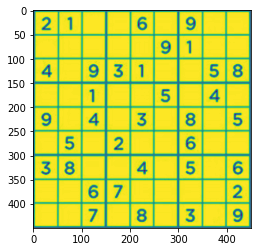

In [28]:
#reshaping outline to get cropped and well defined sudoku
def main_outline(contour):
    biggest = np.array([])
    max_area = 0
    for i in contour:
        area = cv2.contourArea(i)
        if area >50:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i , 0.02* peri, True)
            if area > max_area and len(approx) ==4:
                biggest = approx
                max_area = area
    return biggest ,max_area

def reframe(points):
    points = points.reshape((4, 2))
    points_new = np.zeros((4,1,2),dtype = np.int32)
    add = points.sum(1)
    points_new[0] = points[np.argmin(add)]
    points_new[3] = points[np.argmax(add)]
    diff = np.diff(points, axis =1)
    points_new[1] = points[np.argmin(diff)]
    points_new[2] = points[np.argmax(diff)]
    return points_new

def splitcells(img):
    rows = np.vsplit(img,9)
    boxes = []
    for r in rows:
        cols = np.hsplit(r,9)
        for box in cols:
            boxes.append(box)
    return boxes


black_img = np.zeros((450,450,3), np.uint8)
biggest, maxArea = main_outline(contour)
if biggest.size != 0:
    biggest = reframe(biggest)
    cv2.drawContours(contour_2,biggest,-1, (0,255,0),10)
    pts1 = np.float32(biggest)
    pts2 = np.float32([[0,0],[450,0],[0,450],[450,450]])
    matrix = cv2.getPerspectiveTransform(pts1,pts2)  
    imagewrap = cv2.warpPerspective(sudoku_a,matrix,(450,450))
    imagewrap =cv2.cvtColor(imagewrap, cv2.COLOR_BGR2GRAY)

plt.figure()
plt.imshow(imagewrap)
plt.show()

Splitting cells and classifiying digits

In [29]:
#splitting the sudoku box into 81 cells with empty spaces or digits
sudoku_cell = splitcells(imagewrap)

#cropping cells a bit to avoid misdetection of boundary lines as digits
def CropCell(cells):
    Cells_croped = []
    for image in cells:
        
        img = np.array(image)
        img = img[4:46, 6:46]
        img = Image.fromarray(img)
        Cells_croped.append(img)
        
    return Cells_croped

sudoku_cell_croped= CropCell(sudoku_cell)

# getting predictions and setting the values if probabilities are above 75% 
def read_cells(cell,model):

    result = []
    for image in cell:
        #preprocess the image as it was in the model 
        img = np.asarray(image)
        img = img[4:img.shape[0] - 4, 4:img.shape[1] -4]
        img = cv2.resize(img, (32, 32))
        img = img / 255
        img = img.reshape(1, 32, 32, 1)
        
        predictions = model.predict(img)
        classIndex = np.argmax(model.predict(img),axis=1)
        probabilityValue = np.amax(predictions)
        
        if probabilityValue > 0.32:
            result.append(classIndex[0])
        else:
            result.append(0)
    return result
#getting output as array of 81 digits    
grid = read_cells(sudoku_cell_croped, model)
grid = np.asarray(grid)

Solve the sudoku using DLX algorithm

In [31]:
#reshaping to 9x9 matrix
grid = np.reshape(grid,(9,9))
grid

array([[2, 1, 0, 0, 6, 0, 9, 0, 0],
       [0, 0, 0, 0, 0, 9, 1, 0, 0],
       [4, 0, 9, 3, 1, 0, 0, 5, 8],
       [0, 0, 1, 0, 0, 5, 0, 4, 0],
       [9, 0, 4, 0, 3, 0, 8, 0, 5],
       [0, 5, 0, 2, 0, 0, 6, 0, 0],
       [3, 8, 0, 0, 4, 0, 5, 0, 6],
       [0, 0, 6, 7, 0, 0, 0, 0, 2],
       [0, 0, 7, 0, 8, 0, 3, 0, 9]])

In [46]:
str1 = ""
for i in grid:
  for j in i:
    str1 += str(j)
print(str1)    
#grid in form of string to feed dlx function

210060900000009100409310058001005040904030805050200600380040506006700002007080309


In [49]:
'''Sudoku solver using Donald Knuth's dancing links algorithm
The DLXsudoku class is a subclass of the DLX object in the dlx library and
initializes the exact cover problem. Calling solve then generates all solutions
to the Sudoku board'''


class DLXsudoku(dlx.DLX):
    def __init__(self, grid, dim=3):
        '''Create a DLX instance representing the dim^2 by dim^2 Sudoku board
        represented by grid, which is a string of length dim^4. grid represents
        the contents of the board read from left-to-right and top-to-bottom,
        with entries from {0,...,dim^2}, where 0 represents an empty space in
        the board, and {1,...,dim^2} represent filled entries.'''
        
        # Create the columns.
        ctr = 0
        cols = []

        self.dim = dim
        self.dimsq = dim**2

        # Create the row coverage, which determines that entry j appears in row i.
        for i in range(self.dimsq):
            cols += [(('r',i,j),ctr+j-1) for j in range(1,self.dimsq+1)]
            ctr += self.dimsq

        # Create the column coverage, which determines that entry j appears in column i.
        for i in range(self.dimsq):
            cols += [(('c',i,j),ctr+j-1) for j in range(1,self.dimsq+1)]
            ctr += self.dimsq

        # Create the grid coverage, which determines that entry k appears in grid i,j.
        for i in range(dim):
            for j in range(dim):
                cols += [(('g',i,j,k),ctr+k-1) for k in range(1,self.dimsq+1)]
                ctr += self.dimsq

        # Create the entry coverage, which determines that entry i,j in the grid is occupied.
        for i in range(self.dimsq):
            cols += [(('e',i,j),ctr+j) for j in range(self.dimsq)]
            ctr += self.dimsq

        # Create a dictionary from this, which maps column name to column index.
        sdict = dict(cols)

        # Create the DLX object.
        dlx.DLX.__init__(self, [(colname[0], dlx.DLX.PRIMARY) for colname in cols])

        # Now create all possible rows.
        rowdict = {}
        self.lookupdict = {}
        for i in range(self.dimsq):
            for j in range(self.dimsq):
                for k in range(1,self.dimsq+1):
                    val =  self.appendRow([sdict[('r',i,k)], sdict[('c',j,k)], sdict[('g',i//dim,j//dim,k)], sdict[('e',i,j)]], (i,j,k))
                    rowdict[(i,j,k)] = val
                    self.lookupdict[val] = (i,j,k)

        # Now we want to process grid, which we take to be a string of length 81 representing the puzzle.
        # An entry of 0 means blank.
        for i in range(self.dimsq**2):
            if grid[i] != '0':
                self.useRow(rowdict[(i//self.dimsq,i%self.dimsq,int(grid[i]))])

    def createSolutionGrid(self, sol):
        #Return a two dimensional grid representing the solution.
        # We need to determine what is represented by each row. This is easily accessed by rowname.
        solgrid = [['0']*self.dimsq for i in range(self.dimsq)]
        for a in sol:
            i,j,k = self.N[a]
            solgrid[i][j] = k
        return solgrid


    def createSolutionGridString(self, sol):
        #Create a string representing the solution grid in nice format.

        grid = self.createSolutionGrid(sol)
        return reduce(lambda x,y:x+y, [reduce(lambda x,y:x+y, [str(grid[r][c]) + ('|' if c % self.dim == self.dim-1 and c != self.dimsq-1 else '') for c in range(self.dimsq)], '') + ('\n' if r != self.dimsq-1 else '') + ((('-'*self.dim + '+')*(self.dim-1) + '-'*self.dim + '\n') if r % self.dim == self.dim-1 and r != self.dimsq-1 else '') for r in range(self.dimsq)], '')
                
def checkSudoku(grid, dim=3):
    '''Given a two dimensional array of size dim^2 x dim^2, verify that it is a
    Sudoku board, i.e. that every row is a permutation of {1,...dim^2}, every
    column is a permutation of {1,...,dim^2}, and every subgrid is a permutation
    of dim^2.'''

    dimsq = dim**2

    # Make sure that every row is a permutation.
    for i in range(dimsq):
        if set(grid[i]) != set(range(1,dimsq+1)):
            #print("Row %d failed" % i)
            return False

    # Make sure that every col is a permutation.
    for i in range(dimsq):
        if set([a[i] for a in grid]) != set(range(1,dimsq+1)):
            #print("Column %d failed" % i)
            return False

    # Make sure that every subgrid is a permutation.
    for i in range(dim):
        for j in range(dim):
            if set(reduce(lambda x,y:x+y, [grid[i*dim+k][j*dim:j*dim+dim] for k in range(dim)], [])) != set(range(1,dimsq+1)):
                #print("Subgrid %d,%d failed" % (i,j))
                return False

    return True

d = DLXsudoku(str1,3)
for sol in d.solve():
    print('SOLUTION:')
    print(d.createSolutionGridString(sol))
#finally returns solution of sudoku puzzle in solved grid form

SOLUTION:
215|468|937
738|529|164
469|317|258
---+---+---
621|895|743
974|136|825
853|274|691
---+---+---
382|941|576
196|753|482
547|682|319
